# Explaining Language Models

### Loading Libraries

In [47]:
# Numerical Computing
import numpy as np

# Data Manipulation
import pandas as pd

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# SHAP
import shap

# Time 
import time

# Tabulate
from tabulate import tabulate

# Java Script Object Notation
import json

# TensorFlow
import cv2
import tensorflow as tf

# Transformers
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForCausalLM

# PyTorch
import torch

### Text Classification

In [2]:
# Model
model = pipeline('sentiment-analysis', return_all_scores=True)

# Trial Script
s = ['This product was a scam']

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use mps:0
/opt/anaconda3/envs/ml-explain/lib/python3.10/site-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [3]:
print(model(s)[0][1])

{'label': 'POSITIVE', 'score': 0.0003391575301066041}


In [4]:
explainer = shap.Explainer(model)

shap_values = explainer(s)

print(": % 2f" % shap_values.base_values[0][1])
print(": % 2f" % model(s)[0][1]['score'])

:  0.308739
:  0.000339


In [9]:
# shap.plots.bar(shap_values[0, :, 'POSITIVE'])

### Experimenting with The Masker

In [8]:
masker = shap.maskers.Text(tokenizer=r"\W+")

explainer = shap.Explainer(model, masker=masker)

shap_values = explainer(s)

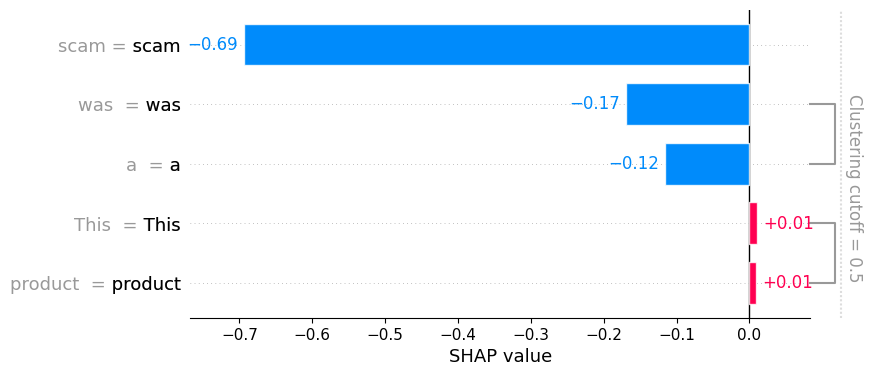

In [10]:
shap.plots.bar(shap_values[0, :, 'POSITIVE'])

In [13]:
s2 = (
    "This product was a scam. "
    "It was more about marketing than technology. "
    "But that's why I loved it. "
    "Learned a bunch about marketing that way."
)

In [16]:
# masker = shap.maskers.Text(tokenizer=r"\.", mask_token=" ")
masker = shap.maskers.Text(tokenizer=r"\s+", mask_token="[MASK]")
explainer = shap.Explainer(model, masker=masker)
shap_values = explainer([s2])

In [17]:
print("Expected: %.2f" % shap_values.base_values[0][1])
print("Prediction: %.2f" %model(s2)[0][1]['score'])

Expected: 0.93
Prediction: 1.00


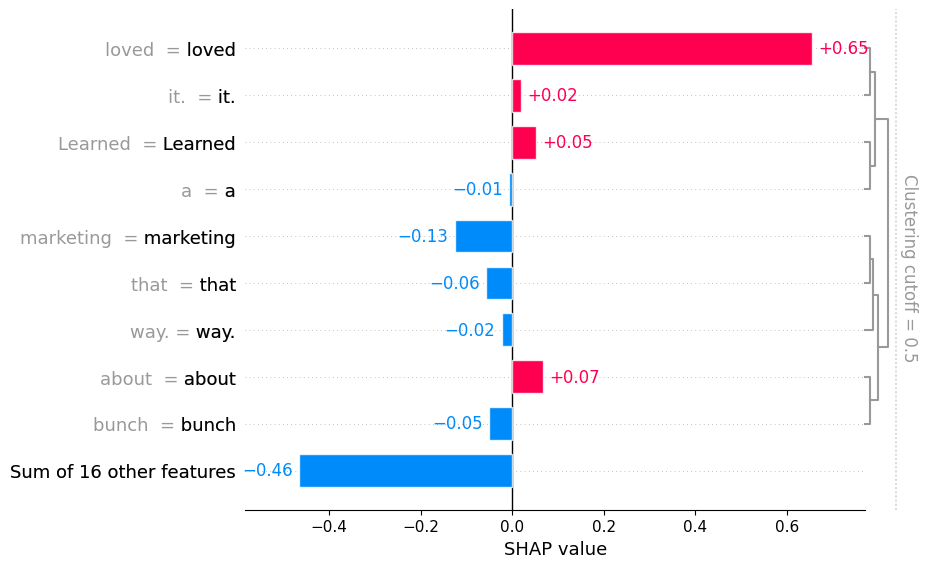

In [18]:
shap.plots.bar(shap_values[0, :, "POSITIVE"])

In [20]:
masker = shap.maskers.Text(tokenizer=r"\.", mask_token="I love it", collapse_mask_token=True)

explainer = shap.Explainer(model, masker=masker)
shap_values = explainer([s2])

print("Expected: %.2f" % shap_values.base_values[0][1])
print("Prediction: %.2f" % model(s2)[0][1]['score'])

Expected: 1.00
Prediction: 1.00


In [23]:
masker = shap.maskers.Text(
    tokenizer=r"\.",
    mask_token="I hate it",
    collapse_mask_token=True
)

explainer = shap.Explainer(model, masker=masker)
shap_values = explainer([s2])

print("Expected: %2.f" % shap_values.base_values[0][1])
print("Prediction: %2.f" % model(s2)[0][1]['score'])

Expected:  0
Prediction:  1


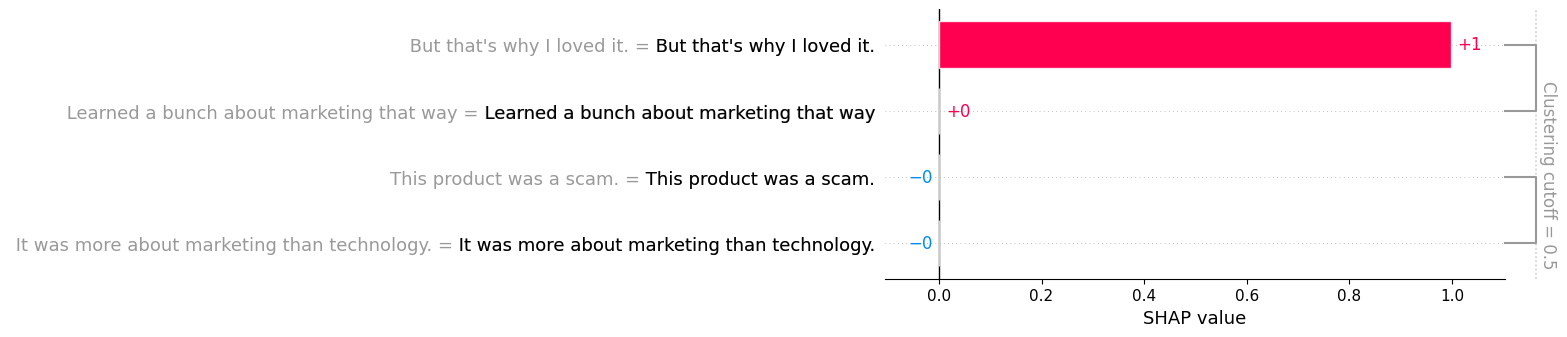

In [24]:
shap.plots.bar(shap_values[0, :, "POSITIVE"])

In [25]:
masker = shap.maskers.Text(
    tokenizer=r"\.", 
    mask_token="...",
    collapse_mask_token=True)

explainer = shap.Explainer(model, masker=masker)
shap_values = explainer([s2])

print("Expected: %.2f" % shap_values.base_values[0][1])
print("Prediction: %.2f" % model(s2)[0][1]['score'])

Expected: 0.96
Prediction: 1.00


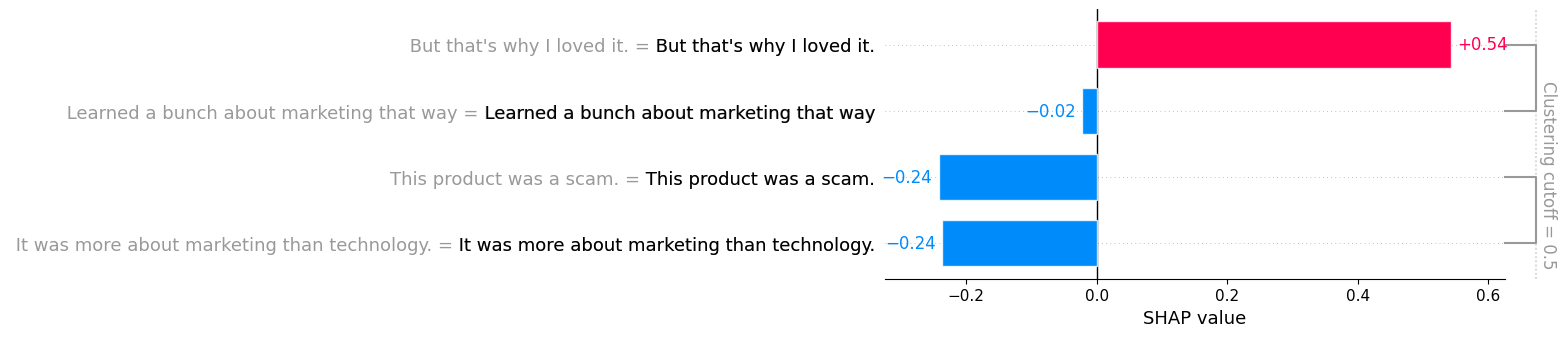

In [26]:
shap.plots.bar(shap_values[0, :, "POSITIVE"])

In [27]:
masker = shap.maskers.Text(
    tokenizer=r"\.", 
    mask_token=' ',
    collapse_mask_token=True)

explainer = shap.Explainer(model, masker=masker)
shap_values = explainer([s2])

print("Expected: %.2f" % shap_values.base_values[0][1])
print("Prediction: %.2f" % model(s2)[0][1]['score'])

Expected: 0.75
Prediction: 1.00


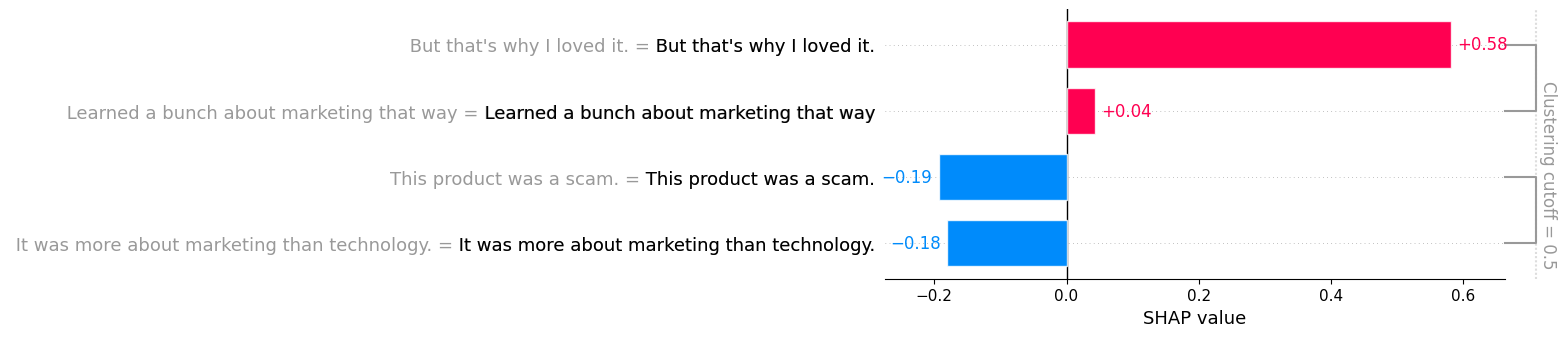

In [28]:
shap.plots.bar(shap_values[0, :, "POSITIVE"])

### Using Logits Instead of Probabilities

In [31]:
model2 = shap.models.TransformersPipeline(
    model, rescale_to_logits=True
)

In [40]:
model2(s)

array([[ 7.9887276 , -7.98870665]])

In [41]:
explainer2 = shap.Explainer(model2)

shap_values2 = explainer2(s)

In [43]:
# shap.plots.bar(shap_values2[0, :, 'POSITIVE'])

### Explaining a Text-to-Text Model

In [48]:
tokenizer = AutoTokenizer.from_pretrained('gpt2')

model = AutoModelForCausalLM.from_pretrained('gpt2')

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [49]:
torch.manual_seed(0)

input_text = 'He insulted Italian cuisine by'

In [50]:
input_ids = tokenizer.encode(input_text, return_tensors='pt')

In [51]:
model.config.do_sample=True

model.config.max_new_tokens = 30

In [54]:
output = model.generate(input_ids)

/opt/anaconda3/envs/ml-explain/lib/python3.10/site-packages/transformers/generation/utils.py:1730: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed in v5. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


In [55]:
output_text = tokenizer.decode(output[0], skip_special_tokens=True)
print('The result: "' + output_text + '"')

The result: "He insulted Italian cuisine by throwing spaghetti at the tables and throwing rocks at the local biker's peloton, and he did something about it by showing that she needs a change"


In [56]:
torch.manual_seed(0)

In [57]:
model.config.is_decoder = True
explainer = shap.Explainer(model, tokenizer)
shap_values = explainer([input_text])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


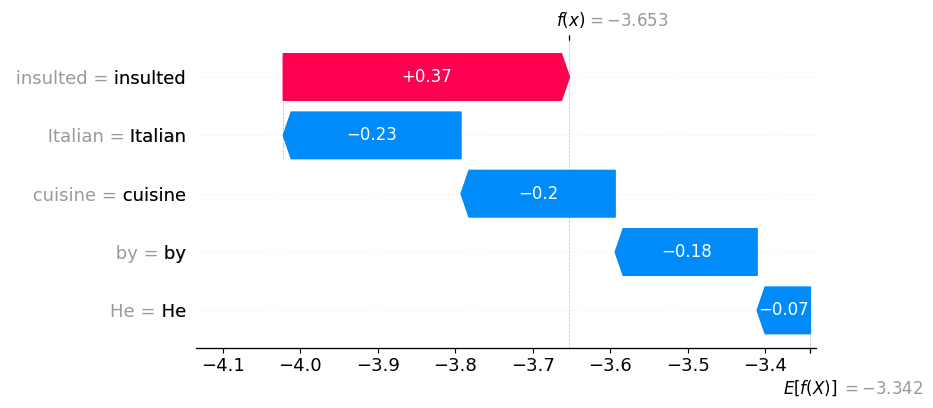

In [58]:
shap.plots.waterfall(shap_values[0, :, 5 + 1])